In [1]:
# -*- coding: utf-8 -*-
from keras.datasets import mnist
import numpy as np


Using TensorFlow backend.


In [2]:
f = np.load('mnist.npz')
x_train, y_train = f['x_train'], f['y_train']
x_test, y_test = f['x_test'], f['y_test']

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [3]:
noise_factor = 0.5
# 均值为0方差为1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


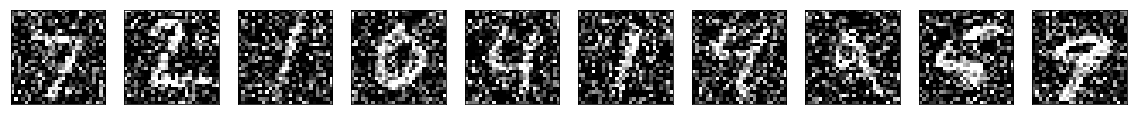

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [7]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model

input_img = Input(shape=(28, 28, 1,)) # N * 28 * 28 * 1

# 卷积
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img) # 28 * 28 * 32
x = MaxPooling2D((2, 2), padding='same')(x) # 14 * 14 * 32
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # 14 * 14 * 32
encoded = MaxPooling2D((2, 2), padding='same')(x) # 7 * 7 * 32

# 开始反卷积
# 7 * 7 * 32
x = Conv2D(32, (3, 3), padding='same', activation='relu')(encoded) # 7 * 7 * 32
x = UpSampling2D((2, 2))(x) # 14 * 14 * 32
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # 14 * 14 * 32
x = UpSampling2D((2, 2))(x) # 28 * 28 * 32
decoded = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x) # 28 * 28 * 1

# 编译网络
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# 训练并保存模型
autoencoder.fit(x_train_noisy, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

autoencoder.save('autoencoder.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 71s 1ms/step - loss: 0.2069 - val_loss: 0.1402
Epoch 2/5
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1269 - val_loss: 0.1196
Epoch 3/5
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1163 - val_loss: 0.1120
Epoch 4/5
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1112 - val_loss: 0.1098
Epoch 5/5
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1083 - val_loss: 0.1052


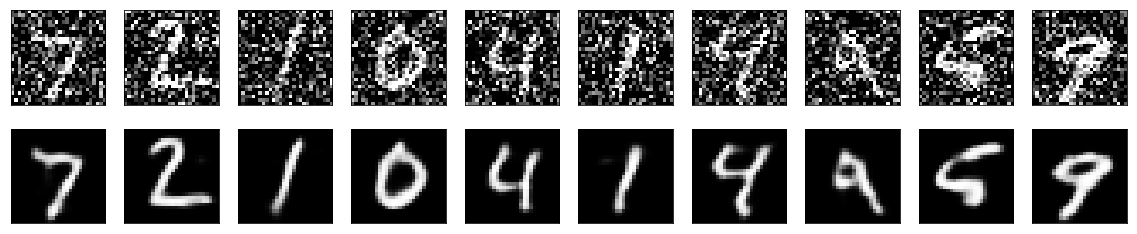

In [8]:
autoencoder = load_model('autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
